# SETUP

In [201]:
import torch
print("CUDA is available:", torch.cuda.is_available())
print("CUDA has version:", torch.version.cuda)


CUDA is available: True
CUDA has version: 11.3


## Multiscale Graph Neural Network

In [202]:
import torch
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from dataprocessing.utils.normalization import normalize
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool import TopKPooling
from torch_geometric.nn.unpool import knn_interpolate
from torch_scatter import scatter
from torch.nn import MSELoss as MSE
from torch_geometric.utils import degree

In [203]:

class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """
        
        out, updated_edges = self.propagate(edge_index, x = x, size = size) # out has the shape of [E, out_channels]
        if x.shape[0] != out.shape[0]:
            print(f'X : {x.shape}')
            print(f'Out : {out.shape}')
        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')
        return out, updated_edges

In [204]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from dataprocessing.utils.helper_pooling import generate_multi_layer_stride
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, args):
        super(GCNConv, self).__init__(aggr='add') # "Add" aggregation.
        self.args = args
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        if not isinstance(edge_index, torch.Tensor):
            edge_index = torch.tensor(edge_index)
        # x has shape [num_nodes, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        #edge_index = add_self_loops(edge_index, num_nodes=x.size(0))
        #print(edge_index[0].shape)
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3-5: Start propagating messages.
        return self.propagate(edge_index.to(self.args.device), size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [num_edges, out_channels]

        # Step 3: Normalize node features.
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [num_nodes, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out

In [205]:
class MessagePassingBlock(torch.nn.Module):
    def __init__(self, hidden_dim,  args, num_layers = None, emb=False):
        super(MessagePassingBlock, self).__init__()
        if num_layers is None:
            self.num_layers = args.num_layers
        else: self.num_layers = num_layers

        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim, hidden_dim, args))
    
    def build_processor_model(self):
        return GCNConv
    
    def forward(self, x, edge_index):
         # Step 1: encode node/edge features into latent node/edge embeddings
         # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x = self.processor[i](x, edge_index)
        return x

class Unpool(nn.Module):
    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, pre_node_num, idx):
        new_h = h.new_zeros([pre_node_num, h.shape[-1]])
        new_h[idx] = h
        return new_h

In [206]:
class WeightedEdgeConv(MessagePassing):
    def __init__(self, args):
        super().__init__(aggr='add', flow='target_to_source')
        self.args = args

    def forward(self, x, g, ew, aggragating=True):
        # aggregating: False means returning
        i = g[0]
        j = g[1]
        if len(x.shape) == 3:
            weighted_info = x[:, i] if aggragating else x[:, j]
        elif len(x.shape) == 2:
            weighted_info = x[i] if aggragating else x[j]
        else:
            raise NotImplementedError("Only implemented for dim 2 and 3")
        weighted_info *= ew.unsqueeze(-1)
        target_index = (j if aggragating else i).to(self.args.device)
        aggr_out = scatter(weighted_info, target_index, dim=-2, dim_size=x.shape[-2], reduce="sum")
        return aggr_out

    @torch.no_grad()
    def cal_ew(self, w, g):
        g = g.to(self.args.device)
        deg = degree(g[0], dtype=torch.float, num_nodes=w.shape[0]).to(self.args.device)
        normed_w = (w.squeeze(-1) / deg)
        i = g[0]
        j = g[1]
        w_to_send = normed_w[i]
        eps = 1e-12
        aggr_w = scatter(w_to_send, j, dim=-1, dim_size=normed_w.size(0), reduce="sum") + eps
        ec = w_to_send / aggr_w[j]
        return ec, aggr_w

In [207]:

class MessagePassingLayer(torch.nn.Module):
    def __init__(self, input_dim_node,hidden_dim, l_n, latent_dim, args):
        super(MessagePassingLayer, self).__init__()
        self.down_gmps = nn.ModuleList()
        self.up_gmps = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = l_n
        self.args = args
        self.bottom_gmp = MessagePassingBlock(hidden_dim=latent_dim, args = self.args, num_layers=4)
        self.edge_conv = WeightedEdgeConv(self.args)

        
        for _ in range(self.l_n):
            self.down_gmps.append(MessagePassingBlock(hidden_dim=latent_dim, args = args))
            self.up_gmps.append(MessagePassingBlock(hidden_dim=latent_dim, args = args))
            self.unpools.append(Unpool())
        
        #self.esn = edge_set_num
        #self.lagrangian = lagrangian

    def forward(self, x, pos, m_ids, m_gs, weights=None):
        # h is in shape of (T), N, F
        # if edge_set_num>1, then m_g is in shape: Level,(Set),2,Edges, the 0th Set is main/material graph
        # pos is in (T),N,D
        # m_ids, m_gs, b_data.x, b_data.y, pen_coeff
        down_outs = []
        cts = []
        h = x
        w = pos.new_ones((pos.shape[-2], 1)) # pen_coeff
        # down pass
        for i in range(self.l_n):
            # message passing
            h = self.down_gmps[i](h, m_gs[i])
            # record the infor before aggregation
            down_outs.append(h)
            # down_ps.append(pos)
            # aggregate then pooling
            # cal edge_weights
            tmp_g = m_gs[i]
            if not torch.is_tensor(m_gs[i]):
                tmp_g = torch.from_numpy(m_gs[i])
            else:
                tmp_g = m_gs[i]
            # Calculates edge and node weigths
            ew, w = self.edge_conv.cal_ew(w, tmp_g)
            # Does edge convolution on nodes with edge weigths
            h = self.edge_conv(h, tmp_g, ew)
            # Does edge convolution on position with edge weights
            # pos = self.edge_conv(pos, tmp_g, ew)
            cts.append(ew)
            # pooling
            h = h[m_ids[i]]
            # pos = pos[m_ids[i]]
            w = w[m_ids[i]]
        h = self.bottom_gmp(h, m_gs[self.l_n])
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            g, idx = m_gs[up_idx], m_ids[up_idx]
            h = self.unpools[i](h, down_outs[up_idx].shape[-2], idx)
            if not torch.is_tensor(g):
                tmp_g = torch.from_numpy(g)
            else:
                tmp_g = g
            h = self.edge_conv(h, tmp_g, cts[up_idx], aggragating=False)
            h = self.up_gmps[i](h, g)
            h = h.add(down_outs[up_idx])
        return h

In [208]:
class MultiScaleAutoEncoder(nn.Module):
    def __init__(self, 
                 input_dim_node, 
                 input_dim_edge, 
                 out_feature_dim, 
                 hidden_dim, 
                 num_layers, 
                 ratio = .5, 
                 latent_dim = None, 
                 args=None):
        super(MultiScaleAutoEncoder, self).__init__()
        self.input_dim_node = input_dim_node
        self.input_dim_edge = input_dim_edge
        self.out_feature_dim = out_feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.ratio = ratio
        if latent_dim is None:
            self.latent_dim = hidden_dim
        self.args = args

        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.down_pool = nn.ModuleList()
        self.up_pool = nn.ModuleList()

        for _ in range(self.num_layers):
            self.down_layers.append(MessagePassingLayer(input_dim_node = self.hidden_dim, 
                                                        hidden_dim = self.hidden_dim, 
                                                        l_n = args.num_layers,
                                                        latent_dim = self.hidden_dim, 
                                                        args = self.args))
            self.up_layers.append(MessagePassingLayer(self.hidden_dim, 
                                                      self.hidden_dim, 
                                                      args.num_layers,
                                                      self.hidden_dim, 
                                                      self.args))
            self.down_pool.append(TopKPooling(self.hidden_dim, self.ratio))
            self.up_pool.append(Unpool())

        self.bottom_layer = MessagePassingLayer(input_dim_node = self.hidden_dim, 
                                                        hidden_dim = self.hidden_dim, 
                                                        l_n = args.num_layers,
                                                        latent_dim = self.hidden_dim, 
                                                        args = self.args)
        
        self.final_layer = MessagePassingLayer(input_dim_node = self.hidden_dim, 
                                                        hidden_dim = self.hidden_dim, 
                                                        l_n = args.num_layers,
                                                        latent_dim = self.hidden_dim, 
                                                        args = self.args)

        self.node_encoder = Sequential(Linear(self.input_dim_node , self.hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, self.latent_dim),
                              LayerNorm(self.latent_dim))
        self.out_node_decoder = Sequential(Linear(self.latent_dim , self.latent_dim//2),
                              ReLU(),
                              Linear(self.latent_dim//2, self.out_feature_dim),
                              LayerNorm(self.out_feature_dim))
        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_encoder = Sequential(Linear(self.input_dim_edge, self.hidden_dim),
                                   ReLU(),
                                   Linear(self.hidden_dim, self.hidden_dim),
                                   LayerNorm(self.hidden_dim))
    def forward(self, data, m_gs, m_ids):
        x = data.x
        edge_attr = data.edge_attr.to(self.args.device)
        edge_index = data.edge_index.to(self.args.device)
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        pos = data.mesh_pos
        m_gs_lst = [m_gs]
        m_ids_lst = [m_ids]
        lst_of_num_nodes = []
        perms = []
        for i in range(self.num_layers):
            lst_of_num_nodes.append(x.shape[0])
            x = self.down_layers[i](x, pos, m_ids, m_gs)
            x, edge_index, edge_attr, _, perm, _ = self.down_pool[i](x, edge_index, edge_attr)
            m_gs, m_ids = generate_multi_layer_stride(edge_index.cpu(), self.args.num_layers, n = x.shape[0])
            perms.append(perm)
            m_gs_lst.append(m_gs)
            m_ids_lst.append(m_ids)

        # Do the final MMP before we arrive at G_L
        x = self.bottom_layer(x, pos, m_ids, m_gs)

        for i in range(self.num_layers):
            m_gs = m_gs_lst.pop()
            m_ids = m_ids_lst.pop()
            n_up = lst_of_num_nodes.pop()
            perm = perms.pop()
            x = self.up_layers[i](x, pos, m_ids, m_gs)
            x = self.up_pool[i](x, n_up, perm)
        
        m_gs = m_gs_lst.pop()
        m_ids = m_ids_lst.pop()

        
        x = self.final_layer(x, pos, m_ids, m_gs)
        x = self.out_node_decoder(x)

        return x#, edge_attr, edge_index
        
        

# TRAIN

In [209]:
import random
import numpy as np
import torch.optim as optim
from dataprocessing.utils.normalization import get_stats
from tqdm import trange
from torch_geometric.loader import DataLoader
from dataprocessing.dataset import MeshDataset

In [210]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'autoencoder',  
         'num_layers': 1,
         'batch_size': 16, 
         'hidden_dim': 64, 
         'epochs': 1,
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'train_size': 100, 
         'test_size': 40, 
         'device':'cuda',
         'shuffle': True, 
         'save_velo_val': True,
         'save_best_model': False, 
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [211]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [212]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device

In [213]:
dataset = MeshDataset(root_dir = 'data/cylinder_flow/', instance_id=1, layer_num=5)
input_dim_node, input_dim_edge = dataset[0].num_features, dataset[0].edge_attr.shape[1]

In [214]:
def MSEloss(pred, inputs, mean_vec_x, std_vec_x):
  #Define the node types that we calculate loss for
  normal=torch.tensor(0)
  outflow=torch.tensor(5)

  #Get the loss mask for the nodes of the types we calculate loss for
  loss_mask=torch.logical_or((torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(0)),
                          (torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(5)))

  #Normalize labels with dataset statistics
  labels = normalize(inputs.x, mean_vec_x, std_vec_x)

  #Find sum of square errors
  error=torch.sum((labels-pred)**2,axis=1)

  #Root and mean the errors for the nodes we calculate loss for
  loss=torch.sqrt(torch.mean(error[loss_mask]))
  return loss

In [215]:
h = 11
num_layers = 1
model = MultiScaleAutoEncoder(input_dim_node, 
                              input_dim_edge, 
                              input_dim_node, 
                              h, 
                              num_layers, 
                              args=args)

scheduler, opt = build_optimizer(args, model.parameters())

# Get Dataset Stats fro normalization
""" stats_list = get_stats(dataset)
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device)) """

loader = DataLoader(dataset, batch_size = 1, shuffle=args.shuffle)
model = model.to(device)


Training:   0%|          | 0/1 [00:00<?, ?Epochs/s]

Total loss : 0.6454676880760861


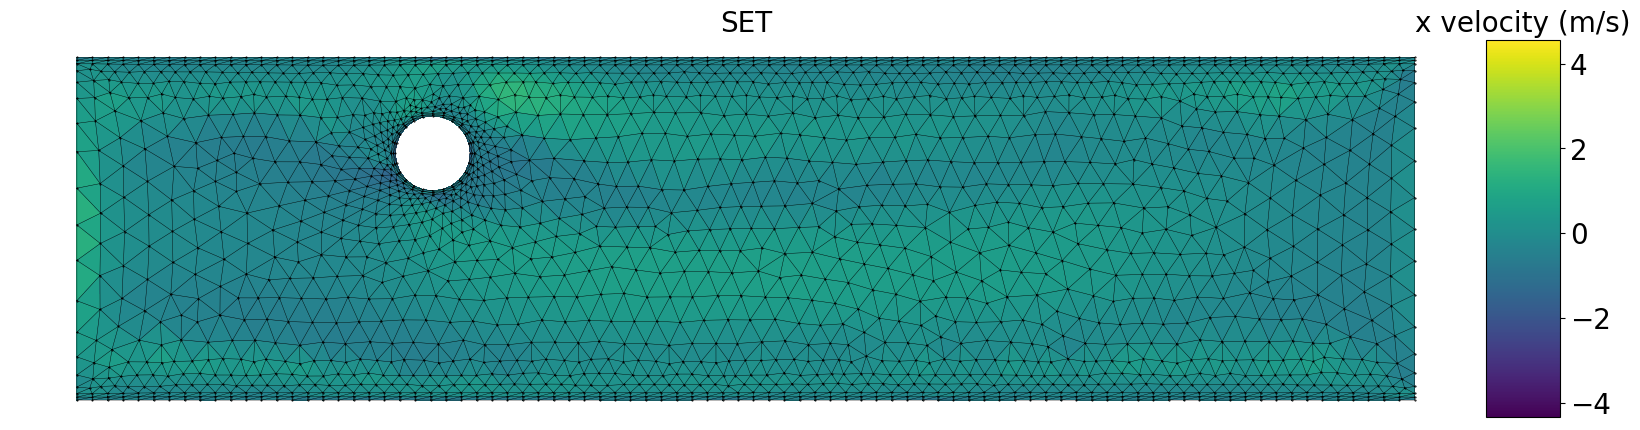

Training: 100%|██████████| 1/1 [1:03:08<00:00, 3788.95s/Epochs]


In [218]:
from matplotlib import pyplot as plt 
from utils.visualization import plot_mesh

losses = []
loss_func = MSE()
mean_vec_y, std_vec_y, mean_vec_x, std_vec_x = dataset.mean_vec_y, dataset.std_vec_y, dataset.mean_vec_x, dataset.std_vec_x
m_gs, m_ids = dataset.m_gs, dataset.m_ids
for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            batch.x = normalize(batch.x, mean_vec_x, std_vec_x)
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            #batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(batch.to(device), m_gs, m_ids)
            loss = loss_func(pred, batch.x)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        print(f'Total loss : {total_loss}')
        losses.append(total_loss)
        plot_g = batch[0]
        plot_g.x = plot_g.x - pred
        with torch.no_grad():
            plot_mesh(plot_g, args)

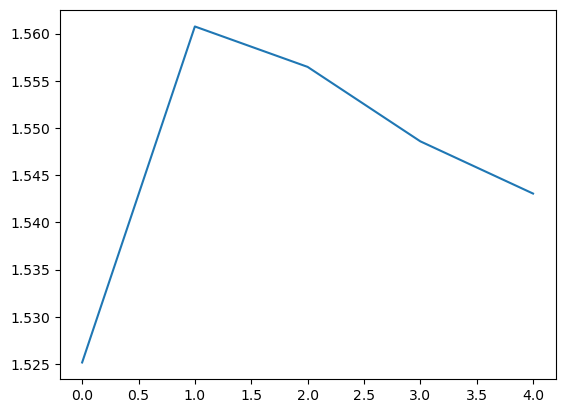

In [ ]:
from matplotlib import pyplot as plt 
from utils.visualization import plot_mesh
plt.plot(losses)

# PLOTS


In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
from torch_geometric.nn import GAE, VGAE, GCNConv
import copy
from torch import tensor
from torch_geometric.loader import DataLoader
from torchmetrics import Accuracy, AveragePrecision, Dice
from utils.visualization import plot_mesh


In [ ]:
samp = next(iter(loader))
pred = model(samp, m_ids, m_gs)
graph = samp[0]
graph.x[:, 0:2] = pred[0]
plot_mesh(graph)


ValueError: Expected 'edge_index' to be two-dimensional (got 1 dimensions)

## Make Predictions

threshold 0.0036939313984168864


c:\Users\aske9\anaconda3\envs\speciale\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


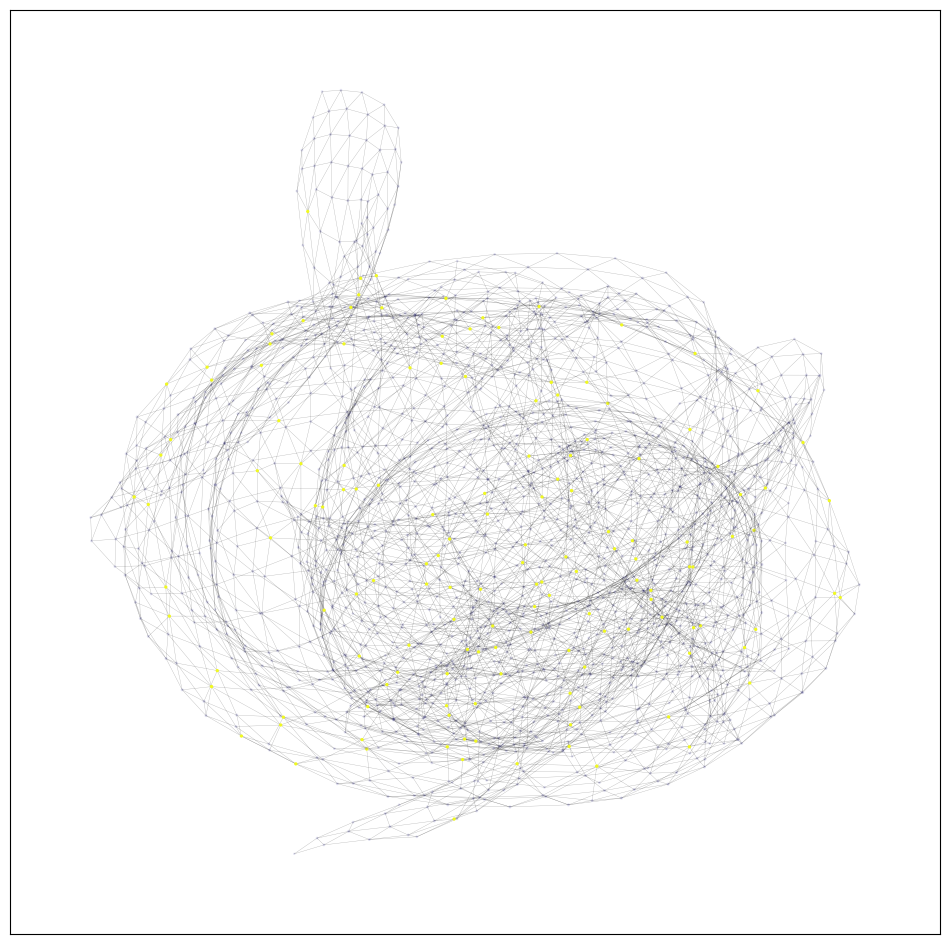

In [ ]:
G = to_networkx(dataset[0], to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [ ]:
print(dataset[0].edge_index)

tensor([[   1,    4,    7,  ..., 1650, 1856, 1353],
        [   0,    3,    6,  ..., 1652, 1857, 1856]])


In [ ]:
from utils.visualization import make_animation
loader = DataLoader(dataset, batch_size = 1)
print(len(loader))
make_animation(dataset, 'delete_me', '', save_anim=True, plot_variables=False)

599
Generating velocity fields...
599


KeyboardInterrupt: 

In [ ]:
import pickle